In [1]:
import os
import numpy as np
import h5py

import matplotlib.pyplot as plt

import ctypes
from ctypes import c_int, c_float, POINTER

from molnet.data._f90 import peaks
from molnet.data.utils import get_image_and_atom_map_cpp

In [2]:
clib = ctypes.CDLL(os.path.join("../molnet/data/_c", "peaks_lib.so"))

fp_p = POINTER(c_float)
int_p = POINTER(c_int)

# fmt: off
clib.peak_dist.argtypes = [
    c_int, c_int, c_int, c_int, fp_p,
    int_p, fp_p,
    fp_p, fp_p, c_float
] # fmt: on

def peak_dist(xyz, grid_dimensions, xyz_start, xyz_step, std):
#def peak_dist(atoms, n_xyz, xyz_start, xyz_step, std):
    nb = 1
    nx, ny, nz = grid_dimensions
    dist = np.empty([nb, nx, ny, nz], dtype=np.float32)
    dist_c = dist.ctypes.data_as(fp_p)
    N_atom = np.array(xyz.shape[0], dtype=np.int32).ctypes.data_as(int_p)
    pos = xyz[:, :3].astype(np.float32).ctypes.data_as(fp_p)
    xyz_start = np.array(xyz_start, dtype=np.float32).ctypes.data_as(fp_p)
    xyz_step = np.array(xyz_step, dtype=np.float32).ctypes.data_as(fp_p)

    # fmt: off
    clib.peak_dist(
        nb, nx, ny, nz, dist_c,
        N_atom, pos,
        xyz_start, xyz_step, std
    ) # fmt: on

    return dist


In [3]:
xyz = np.random.uniform(0, 16, (16, 3))
xyz[:, 2] /= 8 
grid_dimensions = (128, 128, 20)
xyz_start = [0, 0, 0]
xyz_step = [0.125, 0.125, 0.1]
std = 0.2

In [4]:
dist = peak_dist(xyz, grid_dimensions, xyz_start, xyz_step, std)

In [5]:
print(dist.shape)

(1, 128, 128, 20)


In [6]:
def get_image(fname, index, split='train'):
    with h5py.File(fname, 'r') as f:
        x = f[split]['X'][index, 0].transpose(1, 0, 2)
        sw = f[split]['sw'][index, 0]
        xyz = f[split]['xyz'][index]

    def _unpad(xyz):
        return xyz[xyz[:, -1] > 0]
    
    def _top_to_zero(xyz):
        xyz[:, 2] = xyz[:, 2] - xyz[:, 2].max()
        return xyz
    
    def _shift_by_scan_weight(xyz, sw):
        xyz[:, :2] = xyz[:, :2] - sw[0, :2]
        return xyz

    # if all xyzs are zero, return None (padding)
    if np.all(xyz[:, -1] == 0):
        return None, None, None

    xyz = _top_to_zero(_unpad(xyz))
    xyz = _shift_by_scan_weight(xyz, sw)

    # shift scan window
    sw = sw - sw[0]

    return x, sw, xyz


In [7]:
x, sw, xyz = get_image(
    '/l/data/small_fragments/afm.h5',
    0,
    split='train'
)

print(sw)

[[ 0.         0.         0.       ]
 [15.9       15.9        1.9000006]]


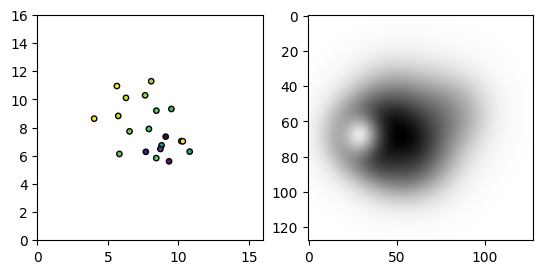

In [8]:
ax = plt.subplot(1, 2, 1)
ax.scatter(
    xyz[:, 0],
    xyz[:, 1],
    c=xyz[:, 2],
    s=15,
    edgecolors='k',
)
ax.set_xlim(0, 16)
ax.set_ylim(0, 16)
ax.set_aspect('equal')

ax = plt.subplot(1, 2, 2)
ax.imshow(x[:, :, 0], cmap='gray')

In [3]:
x, y, xyz = get_image_and_atom_map_cpp(
    fname='/l/data/small_fragments/afm.h5',
    index=0,
    atomic_numbers=np.array([1, 6, 7, 8, 9]),
    split='train',
    z_cutoff=2.0,
    map_resolution=0.125,
    sigma=0.2,
)

In [4]:
print(x.shape)
print(y.shape)
print(xyz.shape)

(128, 128, 10)
(5, 128, 128, 20)
(20, 5)
